# Customer Segmentation 
# Unsupervised and Supervised Learning

Differentiating potential customers is an essential task for organizations. It helps them to increase their revenue and tailor their services to the right customers, while helping them to understand why certain segments of people do not use their services.

Marketing campaigns are more effective the more targeted they are to potential customers. 
Targeted marketing is the process of identifying customers and promoting products and services through media to reach the right group of potential customers. This type of marketing is based on segmentation.

# 1 Project definition
## 1.1 Project Overview
In this project we are going to use real data from *Arvato Financial Solutions GmbH*, to find potential customers for a mail order company.  
We have 3 sets of data:
- Demographics data for customers of the mail-order company: `customer.csv`
- Demographics data for the general population of Germany: `azdias.csv`
- Demographics data for individuals who were targets of a marketing campaign: `mailout_train.csv` and `mailout_test.csv`

## 1.2 Problem Statement
This project will have two stages:
1. **Customer Segmentation**  
In this stage we will make a segmentation of customers, dividing potential customers into several groups, an then identifying those most likely to become customers of the mail order company.<br>
We have two datasets: The first one corresponding to demographics data for customers of the mail-order company `customer.csv`, and the second one to demographics data of a subset of the German population, `azdias.csv`, with the aim of identifying potential customers.

2. **Supervised Learning Model**  
In this stage we will have access to a third dataset with targets from a mail order campaign. Using the previous analysis we will build a machine learning model that predicts whether each individual will respond to the campaign or not.<br>
The dataset is divided into two halves. Using the first one, where we have access to the customer response to the campaign, we will develop a predictive model. The second half lacks the customer response column.<br>
Our goal is to predict the response to the mail-order campaign in this second half of the dataset.<br>
This problem was a competition on the www.kaggle.com website, and although it is over, we can still submit our prediction to get a score from the platform.

## 1.3 Metrics
The metric we will use to evaluate our model will be AUC (**Area Under the Curve**) ROC (**Receiver Operating Characteristics**), as it is one of the most important evaluation metrics to check the performance of any classification model.  
Furthermore, AUC is the metric used in kuggle.com to evaluate the predictions in this dataset, therefore the choice seems quite convenient.

# 2 Analysis
## 2.1 Data Exploration
We load the required libraries and datasets.  
To help us in our analysis, we have at our disposal two files that describe the attributes present in the datasets, as well as the values they can take.  
We are going to use the file **DIAS information Levels - Attributes 2017.xlsx** to which we have added a column with the data type: `num` (numeric), `cat_nom` (nominal categorical) and `cat_ord` (ordinal categorical).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from hermetrics.levenshtein import Levenshtein

In [62]:
customers = pd.read_csv('data/customers.csv')
# azdias = pd.read_csv('data/azdias.csv') #, nrows = 100)
customers.columns = customers.columns.str.lower()
# azdias.columns = azdias.columns.str.lower()

In [68]:
dias_attributes

,attribute,description,value,meaning,type
0,ager_typ,best-ager typology,-1,unknown,cat_nom
1,ager_typ,best-ager typology,0,no classification possible,cat_nom
2,ager_typ,best-ager typology,1,passive elderly,cat_nom
3,ager_typ,best-ager typology,2,cultural elderly,cat_nom
4,ager_typ,best-ager typology,3,experience-driven elderly,cat_nom
...,...,...,...,...,...
2253,zabeotyp,typification of energy consumers,2,smart,cat_nom
2254,zabeotyp,typification of energy consumers,3,fair supplied,cat_nom
2255,zabeotyp,typification of energy consumers,4,price driven,cat_nom
2256,zabeotyp,typification of energy consumers,5,seeking orientation,cat_nom


In [13]:
# customers = pd.read_csv('data/customers.csv')
azdias = pd.read_csv('data/azdias.csv') #, nrows = 100)
# customers.columns = customers.columns.str.lower()
azdias.columns = azdias.columns.str.lower()

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

Let's visualize the customers and azdias dataframes.

The columns **unnamed: 0** and **lnr** are numerical indicators and we can delete them.

In [14]:
customers = customers.drop(columns=['unnamed: 0','lnr'])
azdias = azdias.drop(columns=['unnamed: 0','lnr'])
display(customers)
azdias

,ager_typ,akt_dat_kl,alter_hh,alter_kind1,alter_kind2,alter_kind3,alter_kind4,alterskategorie_fein,anz_haushalte_aktiv,anz_hh_titel,...,vk_zg11,w_keit_kind_hh,wohndauer_2008,wohnlage,zabeotyp,product_group,customer_group,online_purchase,anrede_kz,alterskategorie_grob
0,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,NaN,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,0.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,1,1.0,9.0,NaN,NaN,NaN,NaN,9.0,1.0,0.0,...,5.0,6.0,9.0,1.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
191648,-1,2.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,...,4.0,NaN,9.0,3.0,3,COSMETIC,SINGLE_BUYER,0,2,4
191649,2,1.0,15.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,...,5.0,3.0,9.0,3.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
191650,3,1.0,13.0,NaN,NaN,NaN,NaN,13.0,4.0,0.0,...,1.0,4.0,9.0,2.0,3,FOOD,SINGLE_BUYER,0,2,3


,ager_typ,akt_dat_kl,alter_hh,alter_kind1,alter_kind2,alter_kind3,alter_kind4,alterskategorie_fein,anz_haushalte_aktiv,anz_hh_titel,...,vhn,vk_dht4a,vk_distanz,vk_zg11,w_keit_kind_hh,wohndauer_2008,wohnlage,zabeotyp,anrede_kz,alterskategorie_grob
0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,15.0,0.0,...,2.0,4.0,7.0,8.0,3.0,4.0,3.0,4,2,3
891217,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,11.0,0.0,...,4.0,6.0,9.0,6.0,6.0,9.0,5.0,6,1,2
891218,-1,1.0,17.0,NaN,NaN,NaN,NaN,17.0,3.0,0.0,...,2.0,7.0,10.0,8.0,NaN,5.0,7.0,4,2,2
891219,-1,9.0,0.0,17.0,NaN,NaN,NaN,20.0,7.0,0.0,...,4.0,9.0,8.0,5.0,1.0,9.0,5.0,5,1,1


There are 191652 rows in the customers dataset, each one representing an individual.  
For each customer we have 365 columns (features) + 3 additional columns.  
There are 891221 rows in the azdias dataset, each row represents an individual.  
For each individual we have 365 columns (features)  
The columns that are unique to the customers dataset are:  
**customer_group**, **online_purchase**, **product_group**.

In [15]:
print(customers.shape, azdias.shape)
np.setdiff1d(customers.columns, azdias.columns)

(191652, 368) (891221, 365)


array(['customer_group', 'online_purchase', 'product_group'], dtype=object)

We will extract and save the columns 'customer_group', 'online_purchase', 'product_group', so that both datasets have the same columns.  
When we finish cleaning the data, we will add these columns back to the **customers** datasets.

In [16]:
customers_extra_cols = customers[['customer_group', 'online_purchase', 'product_group']]
pd.DataFrame.to_pickle(customers_extra_cols, 'customers_extra_cols.pkl')
customers = customers.drop(columns = ['customer_group', 'online_purchase', 'product_group'])

In [17]:
print(customers.shape, azdias.shape)

(191652, 365) (891221, 365)


We are going to load the data from the **DIAS information Levels - Attributes 2017** file to which we have added a column with the data type: num (numeric), cat_nom (nominal categorical) and cat_ord (ordinal categorical).

In [18]:
dias_attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', index_col=False, skiprows=1)
dias_attributes.drop('Unnamed: 0', axis=1, inplace=True)
dias_attributes.columns = dias_attributes.columns.str.lower()
dias_attributes.attribute = dias_attributes.attribute.str.lower()
dias_attributes.ffill(inplace=True)
dias_attributes

,attribute,description,value,meaning,type
0,ager_typ,best-ager typology,-1,unknown,cat_nom
1,ager_typ,best-ager typology,0,no classification possible,cat_nom
2,ager_typ,best-ager typology,1,passive elderly,cat_nom
3,ager_typ,best-ager typology,2,cultural elderly,cat_nom
4,ager_typ,best-ager typology,3,experience-driven elderly,cat_nom
...,...,...,...,...,...
2253,zabeotyp,typification of energy consumers,2,smart,cat_nom
2254,zabeotyp,typification of energy consumers,3,fair supplied,cat_nom
2255,zabeotyp,typification of energy consumers,4,price driven,cat_nom
2256,zabeotyp,typification of energy consumers,5,seeking orientation,cat_nom


We can see that the number of columns for which we have information in the DIAS file (314) is less than the number of columns we have in the azdias dataset (365).

In [19]:
print(f'Features in DIAS file: {dias_attributes.attribute.nunique()}')
print(f'Features in azdias file: {azdias.shape[1]}')
print(f'Missing features: {azdias.shape[1] - dias_attributes.attribute.nunique()}')

Features in DIAS file: 314
Features in azdias file: 365
Missing features: 51


Features in azdias file without information:

In [20]:
unknown_col = np.setdiff1d(azdias.columns, dias_attributes.attribute.unique())
print(len(unknown_col))

93


There are more features without information (93) than expected (51).  
Maybe they are stored in the DIAS and azdias files with slightly different names.  
In order to use the information provided in the `DIAS` file for our analysis, we need the attributes of the `DIAS` and `AZDIAS` files to be written exactly the same.  
So first we have to homogenize the nomenclature of the attributes before starting with the actual data analysis.  
For this purpose, we will use the *hermetircs* library to calculate the similarity between the attribute names in both files.

In [13]:
from hermetrics.levenshtein import Levenshtein
lev = Levenshtein()

As an example, let us calculate the similarity between two attributes stored with slightly different names:  
`d19_banken_gross_rz` and `d19_banken_gross`.


We can see that the similarity in this case is 0.84.
Let's therefore look for attributes with a similarity greater than 0.7

In [16]:
lev.similarity('d19_banken_gross_rz','d19_banken_gross')

0.8421052631578947

In [16]:
n=0
pairs = []
for feature_az in np.setdiff1d(azdias.columns,dias_attributes.attribute.unique()):
    for feature_dias in np.setdiff1d(dias_attributes.attribute.unique(),azdias.columns):    
        if lev.similarity(feature_az,feature_dias) > 0.7:
            print(f'AZDIAS: {feature_az:_<30} DIAS: {feature_dias}')
            pairs.append((feature_az,feature_dias))
            n +=1
print(n)

AZDIAS: cameo_intl_2015_______________ DIAS: cameo_deuintl_2015
AZDIAS: d19_banken_direkt_____________ DIAS: d19_banken_direkt_rz
AZDIAS: d19_banken_gross______________ DIAS: d19_banken_gross_rz
AZDIAS: d19_banken_lokal______________ DIAS: d19_banken_lokal_rz
AZDIAS: d19_banken_rest_______________ DIAS: d19_banken_rest_rz
AZDIAS: d19_bekleidung_geh____________ DIAS: d19_bekleidung_geh_rz
AZDIAS: d19_bekleidung_geh____________ DIAS: d19_bekleidung_rest_rz
AZDIAS: d19_bekleidung_rest___________ DIAS: d19_bekleidung_geh_rz
AZDIAS: d19_bekleidung_rest___________ DIAS: d19_bekleidung_rest_rz
AZDIAS: d19_bildung___________________ DIAS: d19_bildung_rz
AZDIAS: d19_bio_oeko__________________ DIAS: d19_bio_oeko_rz
AZDIAS: d19_buch_cd___________________ DIAS: d19_buch_rz
AZDIAS: d19_digit_serv________________ DIAS: d19_digit_serv_rz
AZDIAS: d19_drogerieartikel___________ DIAS: d19_drogerieartikel_rz
AZDIAS: d19_energie___________________ DIAS: d19_energie_rz
AZDIAS: d19_freizeit_________________

### Problems encountered with the writing of some attributes
- We see that many features in the **DIAS** file end with *_rz*, and therefore do not match the feature in the **azdias** file.  
- Also the feature *d19_kk_kundentyp* appears in the **azdias** file as *kk_kundentyp*.  
- The feature *cameo_intl_2015* appears as *cameo_deuintl_2015* in the **DIAS** file.
- The feature *d19_buch_cd* appears as *d19_buch* in the **DIAS** file.
- Feature *kba13_ccm_1401_2500* appears as *kba13_ccm_1400_2500* in the **DIAS** file.
- The *bip_flag* feature is in DIAS but not in azdia, it could be the *dsl_flag* column.  
- The feature *geoscore_kls7* does not appear in azdia, we will remove it from the DIAS file.  
- Feature *haushaltsstruktur* does not appear in azdias, remove it from DIAS file  
- Feature *soho_flag* appears in azdias as *soho_kz*  
- Feature *wachstumsgebiet_nb* does not appear in azdias, we will remove it from the DIAS file.  
- The feature *bip_flag* is in DIAS but not in azdia, it could be the *dsl_flag* column.
- The feature *soho_flag* appears in azdias as *soho_kz*

Let's check that the values that appear in the **DIAS** file and those that appear in the **azdias** file are in the same range of values.

### 2.1.1 `DIAS` atributes

In [18]:
for pair in pairs:
    print(pair)
    print(azdias[pair[0]].value_counts().sort_index().index.to_list())
    print(sorted(dias_attributes.loc[dias_attributes.attribute == pair[1]].value.unique()))
    print()
#     dias_attributes.loc[dias_attributes.attribute == pair[1]]

('cameo_intl_2015', 'cameo_deuintl_2015')
[12.0, 13.0, 14.0, 15.0, 22.0, 23.0, 24.0, 25.0, 31.0, 32.0, 33.0, 34.0, 35.0, 41.0, 43.0, 44.0, 45.0, 51.0, 52.0, 54.0, 55.0]
[-1, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 41, 42, 43, 44, 45, 51, 52, 53, 54, 55]

('d19_banken_direkt', 'd19_banken_direkt_rz')
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7]

('d19_banken_gross', 'd19_banken_gross_rz')
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 7]

('d19_banken_lokal', 'd19_banken_lokal_rz')
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7]

('d19_banken_rest', 'd19_banken_rest_rz')
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7]

('d19_bekleidung_geh', 'd19_bekleidung_geh_rz')
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7]

('d19_bekleidung_geh', 'd19_bekleidung_rest_rz')
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7]

('d19_bekleidung_rest', 'd19_bekleidung_geh_rz')
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7]

('d19_bekleidung_rest', 'd19_bekleidung_rest_rz')

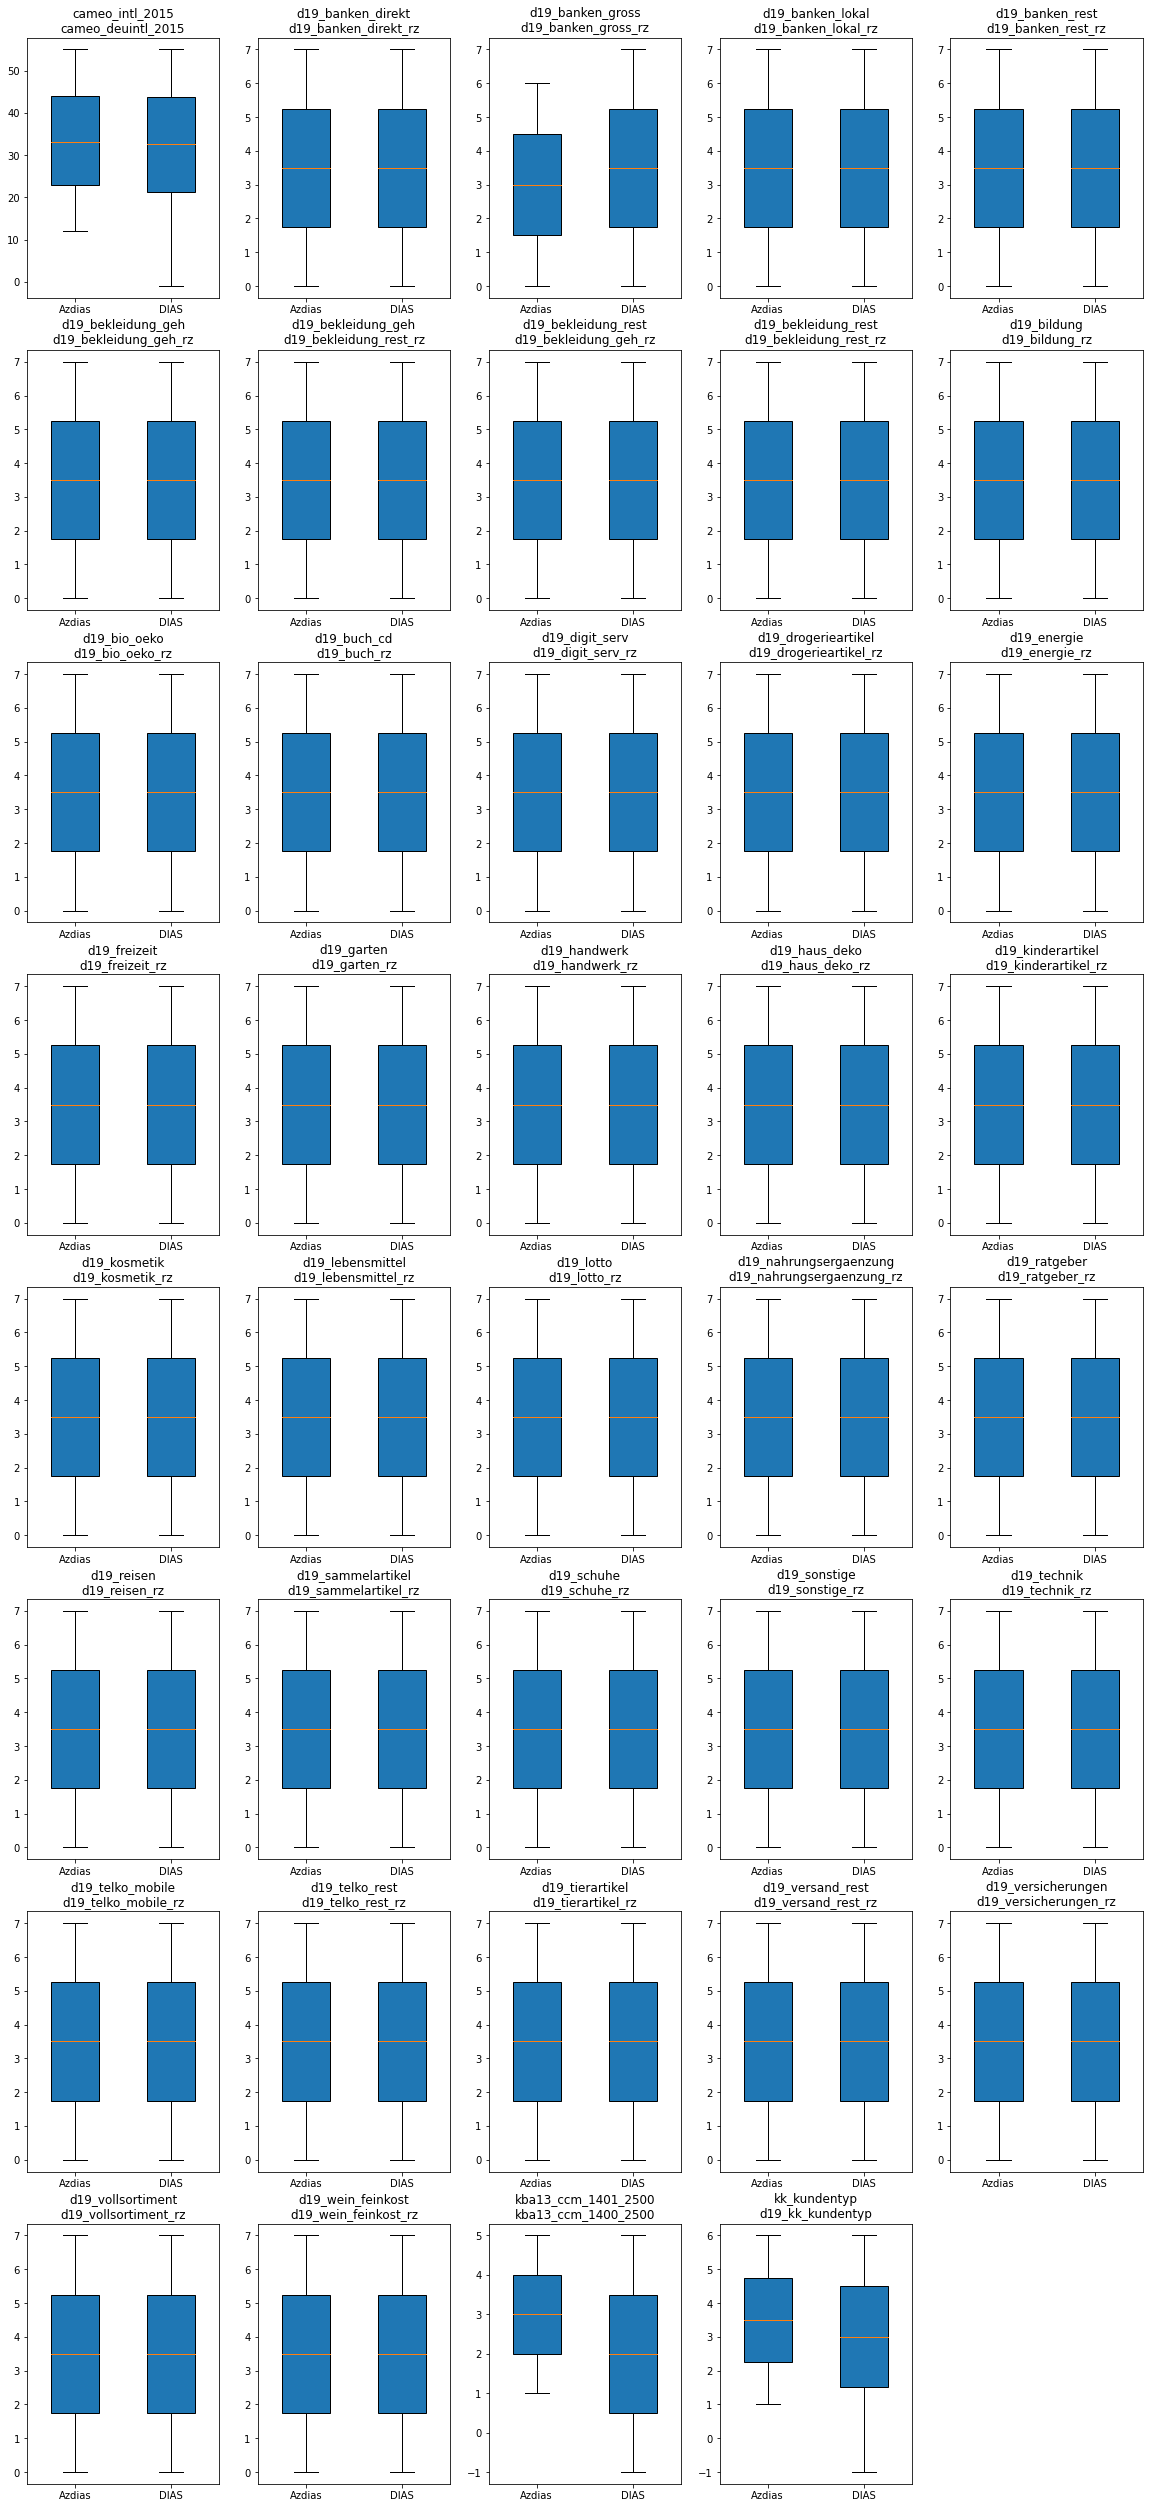

In [14]:
plt.figure(figsize=(20,45))
for n in range(len(pairs)):
    plt.subplot(8,5,n+1)
    plt.boxplot((azdias[pairs[n][0]].value_counts().index,
                sorted(dias_attributes.loc[dias_attributes.attribute == pairs[n][1]].value.unique()))
                ,vert=True, labels =['Azdias','DIAS'],patch_artist=True,widths=0.5,autorange = True, #whis=(0.1,0.9)
               )
    plt.title(pairs[n][0]+'\n' + pairs[n][1])
plt.show()

Let's make changes to the feature names:
Let's remove the last `_rz` characters from the features in the **days** file.  
Let's rename the *d19_kk_kundentyp* feature to *kk_kundentyp*.  

In [21]:
def remove_rz(x):
    '''
    Removes the last three characters '_rz' from a feature name
    INPUT:
    x STR: The feature name that we want to rename, removing the '_rz' from the end
    OUTPUT
    x STR: The renamed feature
    EXAMPLE
    "d19_bekleidung_rest_rz" --> "d19_bekleidung_rest"
    '''
    try:
        if x[-2:] =='rz':
            return x[:-3] 
    except:
        return np.nan
    return x
dias_attributes.attribute = dias_attributes.attribute.apply(remove_rz)

dias_attributes.attribute = dias_attributes.attribute.replace({
    'd19_kk_kundentyp':'kk_kundentyp',
    'cameo_deuintl_2015':'cameo_intl_2015',
    'd19_buch':'d19_buch_cd',
    'kba13_ccm_1400_2500':'kba13_ccm_1401_2500',
    'bip_flag':'dsl_flag',
    'soho_flag':'soho_kz',
})

dias_attributes = dias_attributes.loc[(dias_attributes.attribute != 'geoscore_kls7')
                                      & (dias_attributes.attribute != 'haushaltsstruktur')
                                      & (dias_attributes.attribute != 'wachstumsgebiet_nb')
                    ]


We have already fixed the differences where the same characteristics were recorded in the two files.  
We are going to store the columns for which we have no information.  
The only thing we will be able to do with them is a numerical analysis of the values.

In [22]:
unknown_col = np.setdiff1d(azdias.columns, dias_attributes.attribute.unique())
unknown_feat = np.setdiff1d(dias_attributes.attribute.unique(),azdias.columns)
print(f'Features in DIAS file not present in azdias file: {len(unknown_feat)}')
print(f'Features in azdias file not present in  file DIAS: {len(unknown_col)}')

Features in DIAS file not present in azdias file: 0
Features in azdias file not present in  file DIAS: 54


In the `DIAS` file, we see that many attributes are coded as numerical categorical variables, and the value for missing values varies between -1, 0, 9....  
We also find missing values in the dataset.  
This means that we have several encodings for the same situation.  
We will encode all these situations as np.NAN.

In [13]:
unknowns= (dias_attributes
 .loc[dias_attributes.meaning.str.contains('unknown')]
 .assign(value = dias_attributes.value.map(str).str.split(','))
)
unknowns

,attribute,description,value,meaning,type
0,ager_typ,best-ager typology,[-1],unknown,cat_nom
5,alterskategorie_grob,age classification through prename analysis,"[-1, 0]",unknown,cat_ord
11,alter_hh,main age within the household,[0],unknown / no main age detectable,cat_ord
33,anrede_kz,gender,"[-1, 0]",unknown,cat_nom
40,ballraum,distance to next urban centre,[-1],unknown,cat_ord
...,...,...,...,...,...
2216,vers_typ,insurance typology,[-1],unknown,cat_nom
2219,wohndauer_2008,length of residence,"[-1, 0]",unknown,cat_ord
2229,wohnlage,residential-area,[-1],unknown,cat_ord
2244,w_keit_kind_hh,likelihood of a child present in this household,"[-1, 0]",unknown,cat_ord


In [71]:
def change_unknown_to_nan(df):
    '''
    Convert the unknown values of the dataset (-1, 0, 9... according to the DIAS file) to np.nan
    Also for the column geburtsjahr (birth year), chage 0 to NAN
    INPUT
    df DATAFRAME: pandas dataframe with the values we want to convert into nans
    OUTPUT
    df DATAFRAME: pandas dataframe with the values converted
    '''
    # Creating a dataframe from the DIAS file, with the unknown values
    unknowns= (dias_attributes
     .loc[dias_attributes.meaning.str.contains('unknown')]
     .assign(value = dias_attributes.value.map(str).str.split(','))
    )
    for col in unknowns.attribute.values:
        values = unknowns.query('attribute == @col').value.values[0]
        for value in values:
            df[col] = df[col].replace(int(value), np.nan)
    df['geburtsjahr'] =  df['geburtsjahr'].replace({0 : np.nan})
    return df

In [24]:
azdias = change_unknown_to_nan(azdias)
customers = change_unknown_to_nan(customers)

Let's study the 50 columns with more missing values

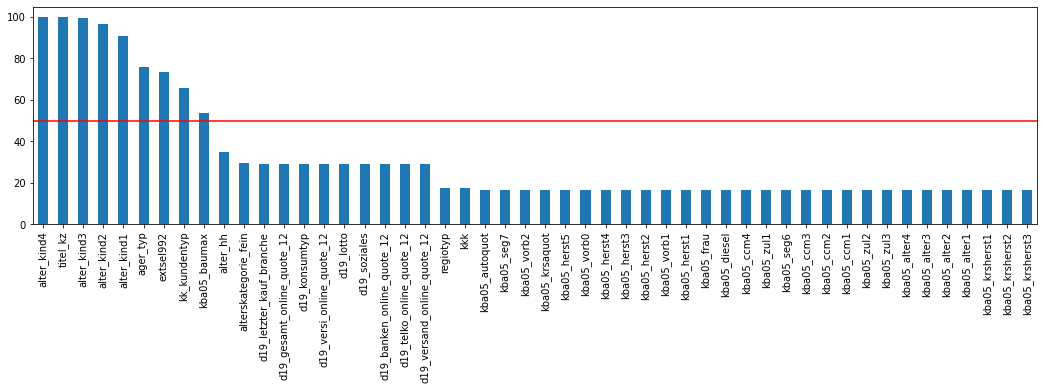

In [17]:
plt.figure(figsize=(18,4))
(azdias.isnull().mean().sort_values(ascending=False)*100).head(50).plot(kind='bar')
plt.axhline(y=50, c='r')
plt.show()

Let's look at the columns with more than 50% missing values.

In [26]:
(azdias.isnull().mean().sort_values(ascending=False)*100).head(9)

alter_kind4     99.864792
titel_kz        99.757636
alter_kind3     99.307691
alter_kind2     96.690047
alter_kind1     90.904837
ager_typ        76.019640
extsel992       73.399639
kk_kundentyp    65.596749
kba05_baumax    53.468668
dtype: float64

In [18]:
cols = azdias.columns[azdias.isnull().mean()>0.5]
print(cols)

Index(['ager_typ', 'alter_kind1', 'alter_kind2', 'alter_kind3', 'alter_kind4',
       'extsel992', 'kba05_baumax', 'kk_kundentyp', 'titel_kz'],
      dtype='object')


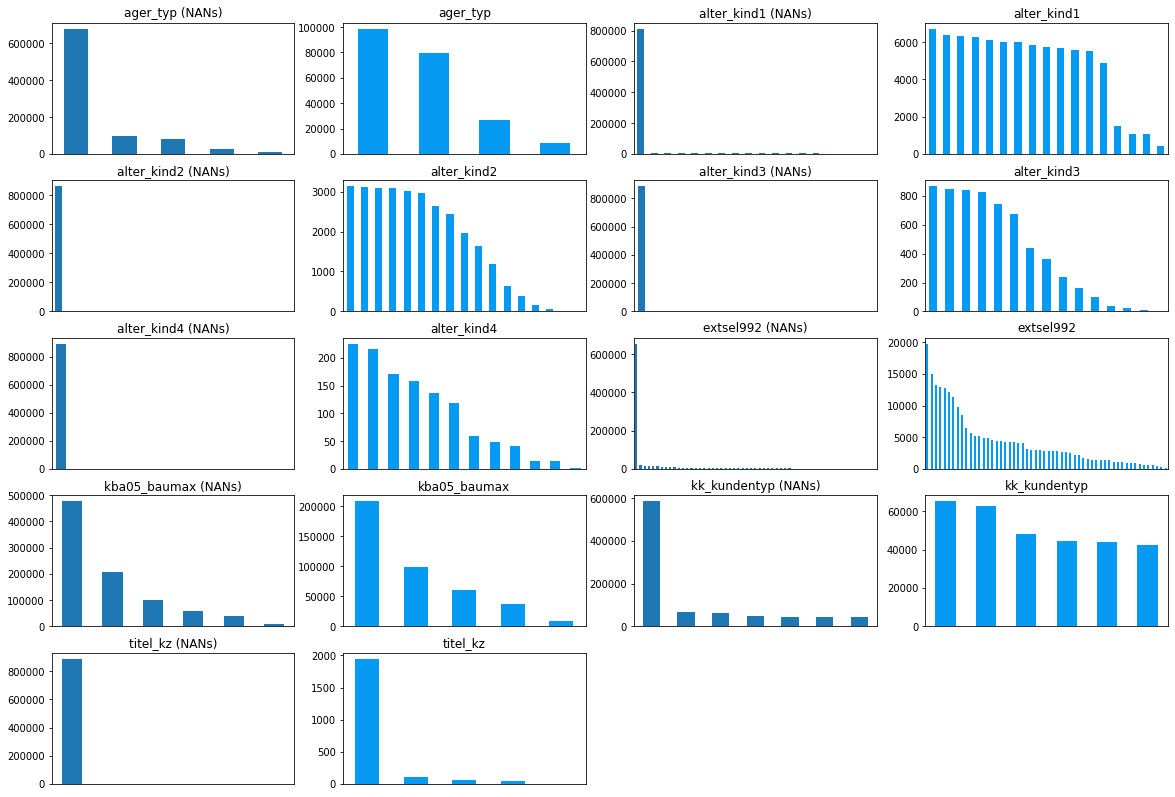

In [24]:
plt.figure(figsize=(20,14))
for n in range(0,len(cols)):
    plt.subplot(5,4,2*n+1)
    plt.title(cols[n] + ' (NANs)')
    azdias[cols[n]].value_counts(dropna=False).plot(kind='bar')
    plt.xticks([])
    plt.subplot(5,4,2*n+2)
    azdias[cols[n]].value_counts(dropna=True).plot(kind='bar', color='#069aF3')
    plt.title(cols[n])
    plt.xticks([])

# Comparative graph of these columns with and without missing values

It seems that the columns **alter_kind1,2,3 and 4** store the age of the first child, second child, etc...  
We could create two columns, one with the total number of children, the other with the average of the ages of the children, and then delete the *alter_kind* columns. But even the column with the age of the first child has 90.9% missing values, so in this case, we will simply delete those columns.  
The column **titel_kz** studies whether a person has an academic degree, and it has 99.76% of null values, so, without null values, we see that almost all the entries are 0, so we will delete it.  
We will eliminate all columns with more than 50% missing values.

In [25]:
def get_columns_to_drop_nan(df, percent = 0.5):
    '''
    Get the columns to drop with the specified percentage of missing values
    from a given dataframe
    INPUT:
    df DATAFRAME: the dataframe in which we want to find the columns with missing values
    percent FLOAT: threshold of percentage of nulls to be selected (between 0 and 1)
    OUTPUT:
    cols LIST: a list of columns with more null values than the specified threshold
    '''
    cols = df.columns[df.isnull().mean()>0.5]
    return cols

In [26]:
column_with_nan = get_columns_to_drop_nan(azdias, percent = 0.5)
azdias = azdias.drop(columns=column_with_nan)
customers = customers.drop(columns=column_with_nan)

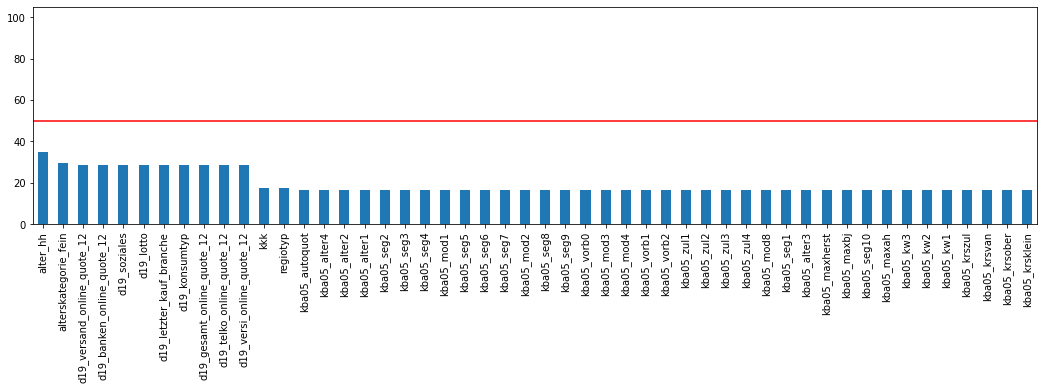

In [21]:
plt.figure(figsize=(18,4))
(azdias.isnull().mean().sort_values(ascending=False)*100).head(50).plot(kind='bar')
plt.axhline(y=50, c='r')
plt.ylim(0,105)
plt.show()

We will look for those columns with a value with a frequency greater than 90%.  
These columns will not help the model to segment the customers.  
Finally we found 32 columns, which we are going to eliminate.

In [27]:
col_similar = []
for col in azdias.columns:
    if azdias[col].value_counts(normalize=True).max()>0.9:
        col_similar.append(col)

In [28]:
len(col_similar)

32

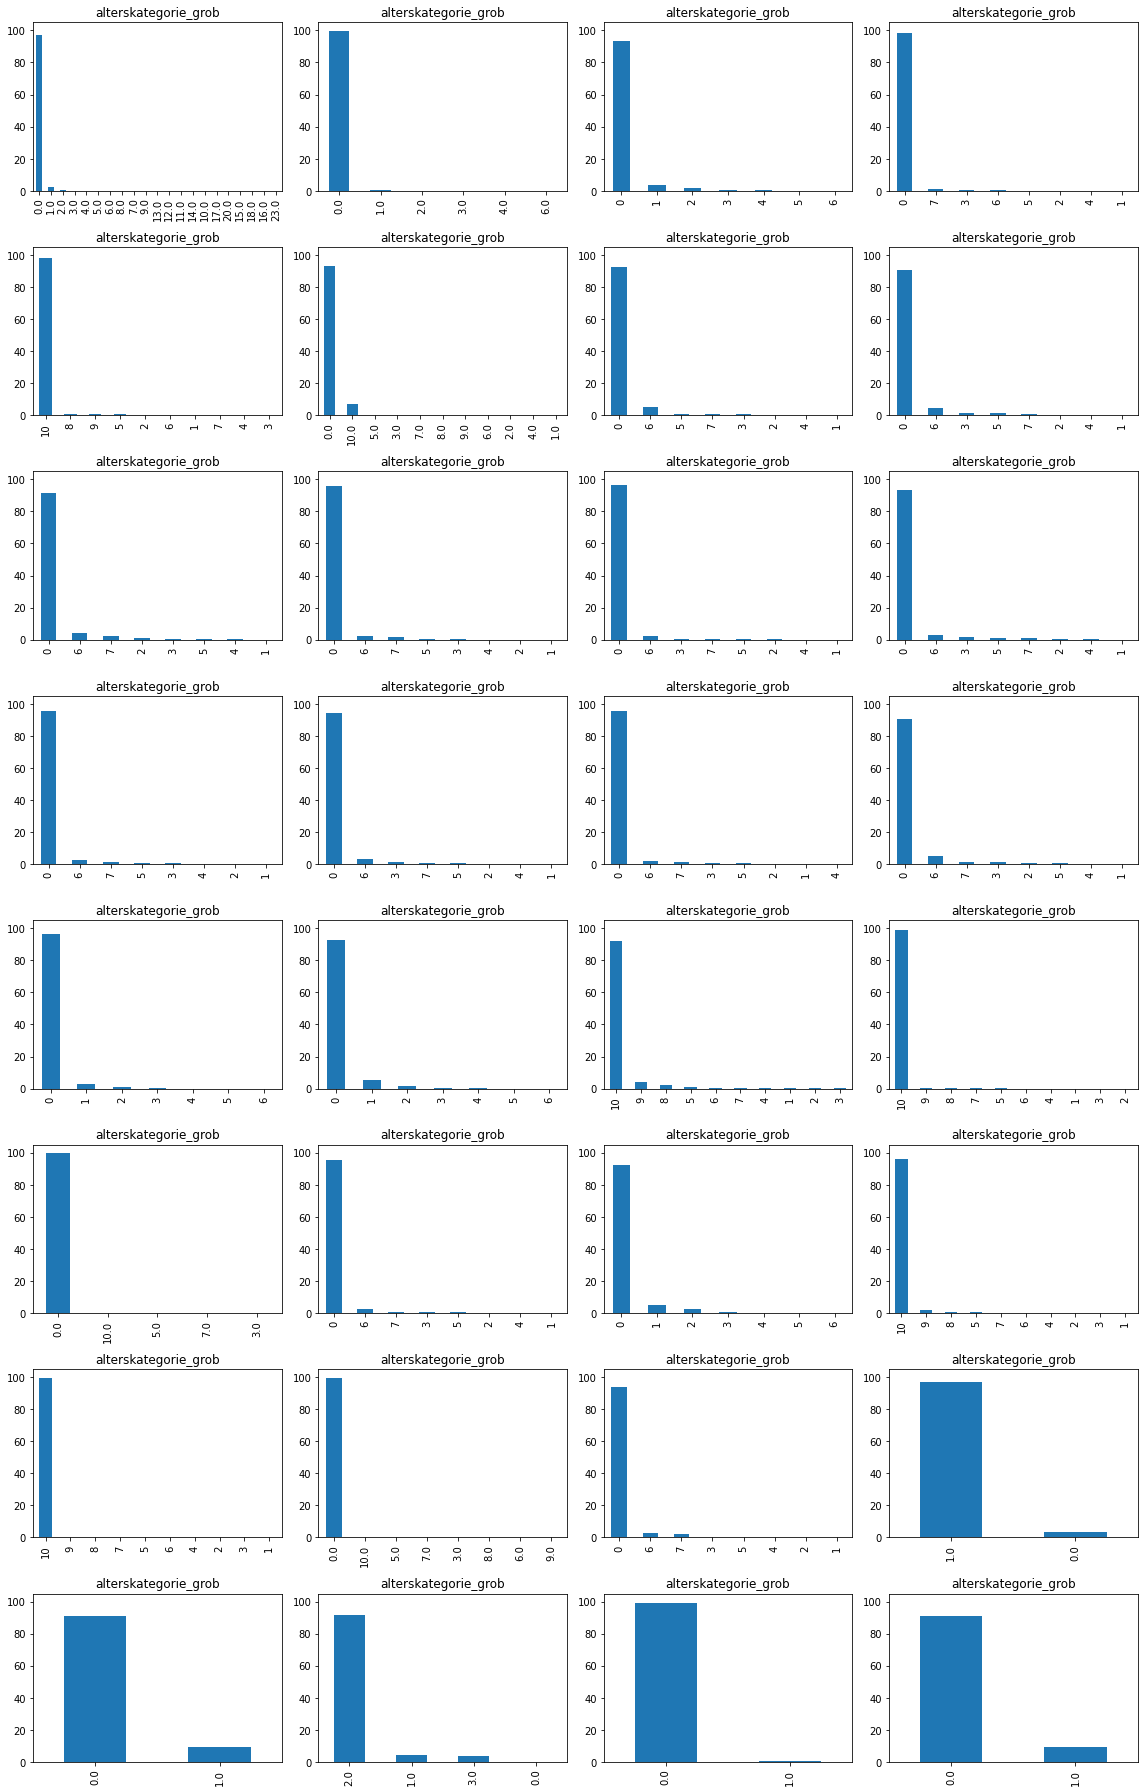

In [30]:
plt.figure(figsize=(16,25))
for n in range(len(col_similar)):
    plt.subplot(8,4,n+1)
    (azdias[col_similar[n]].value_counts(normalize=True)*100).plot(kind='bar')
    plt.ylim(0,105)
    plt.title(col)
    plt.tight_layout()

In [29]:
def get_unbalanced_columns(df, percent=0.9):
    '''
    Get columns with a dominant value above a specified threshold
    INPUT:
    df DATAFRAME: pandas dataframe in which we want to find the columns
    percent FLOAT: frequency threshold for the dominant value (between 0 and 1)
    OUTPUT:
    cols LIST: list with unbalanced columns
    '''
    col_similar = []
    for col in df.columns:
        if df[col].value_counts(normalize=True).max()>0.9:
            col_similar.append(col)
    return col_similar

In [30]:
col_similar = get_unbalanced_columns(azdias, percent=0.9)
azdias = azdias.drop(columns = col_similar)
customers = customers.drop(columns = col_similar)

In [31]:
azdias.shape

(891221, 324)

### Ordinal categorical columns
There are 252 ordinal categorical columns.  
The column **cameo_deu_2015** is a concretion of the column **CAMEO_DEUG_2015**.  

| CAMEO_DEUG_2015 | cameo_deu_2015 |
|:-|:-|
|1. upper class|1A Work-Life-Balance|
|  |1B Wealthy Best Ager|
|  |1C Successful Songwriter|
|  |1D Old Nobility|
|  |1D Old Nobility|
| | 1E City Nobility|
|2.	upper middleclass|2A	Cottage Chic|
| |2B	Noble Jogger|
| |2C	Established gourmet|
| |2D	Fine Management|
|...|...|

Since the **CAMEO_DEUG_2015** column has a certain order, let's keep the **cameo_deu_2015** column as ordinal categorical.  
Let's replace the values by numbers.
1A -> 1  
1B -> 2  
1C -> 3  
1D -> 4  
1E -> 5  
2A -> 6  
...

In addition, some missing values were stored as 'XX' characters. We will treat them as if they were NANs. 

In [59]:
cat_ord = dias_attributes.loc[dias_attributes.type == 'cat_ord'].attribute.values
cat_ord = np.intersect1d(cat_ord, azdias.columns)
print(len(cat_ord))

252


In [33]:
azdias.cameo_deu_2015.unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object)

In [34]:
def cameo_deu_2015_to_numerical(df):
    '''
    Convert the column cameo_deu_2015 to numerical
    INPUT
    df DATAFRAME: pandas dataframe with a categorical cameo_deu_2015 column, with string values, that we want to
                  to convert in numerical values
    OUTPUT
    df DATAFRAME: pandas dataframe with the cameo_deu_2015 column converted into numerical values
    '''
    values = sorted(df.cameo_deu_2015.dropna().unique())
    df.cameo_deu_2015 = df.cameo_deu_2015.map({values[n]:n+1 for n in range(len(values)-1)})
    return df

In [35]:
azdias = cameo_deu_2015_to_numerical(azdias)
customers = cameo_deu_2015_to_numerical(customers)

In [36]:
azdias.shape, customers.shape

((891221, 324), (191652, 324))

### Nominal category columns

In [37]:
cat_nom = dias_attributes.loc[dias_attributes.type == 'cat_nom'].attribute.values
cat_nom = np.intersect1d(cat_nom, azdias.columns)
print(len(cat_nom))

24


We will use one-hot-encoding to convert these nominal variables into something the model can use to segment customers. 

In [38]:
def get_dummies_drop(df, col):
    '''
    Get dummie variables for one column, drop the original column from the dataframe,
    and concatenate the dummie variable columns to the original dataframe
    INPUT
    df DATAFRAME: pandas dataframe with the column we want to convert into dummy variables
    col STRING: the name of the column we want to convert into dummy variables
    OUTPUT
    df DATAFAME: pandas dataframe with the dummy variables columns 
    '''
    return pd.concat([df.drop(columns = col),
                   pd.get_dummies(df[col], prefix=col, drop_first=True)
                  ], axis=1)

In [39]:
azdias.shape , customers.shape

((891221, 324), (191652, 324))

In [40]:
for col in cat_nom:
    azdias = get_dummies_drop(azdias, col)
for col in cat_nom:
    customers = get_dummies_drop(customers, col)

In [41]:
azdias.shape , customers.shape

((891221, 473), (191652, 472))

In [42]:
np.setdiff1d(azdias.columns, customers.columns)

array(['gebaeudetyp_5.0'], dtype=object)

There is a value in the *gebaeudetyp* column that did not appear in the **customers** dataet but in the **azdias**, so when hot-encoding, an extra column has appeared in **azdias**: *gebaeudetyp_5.0*. 

In order to join both datasets later, we want them to have the same columns, so we will create that column in **customers**, with all values equal to 0.

In [43]:
customers['gebaeudetyp_5.0']= 0

In [44]:
azdias.shape , customers.shape

((891221, 473), (191652, 473))

### Columns type 'object'

In [45]:
azdias.select_dtypes('object')

,d19_letzter_kauf_branche,eingefuegt_am
0,NaN,NaN
1,NaN,1992-02-10 00:00:00
2,D19_UNBEKANNT,1992-02-12 00:00:00
3,D19_UNBEKANNT,1997-04-21 00:00:00
4,D19_SCHUHE,1992-02-12 00:00:00
...,...,...
891216,D19_HAUS_DEKO,1992-02-10 00:00:00
891217,D19_UNBEKANNT,1992-02-10 00:00:00
891218,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00
891219,D19_UNBEKANNT,1992-02-12 00:00:00


In [40]:
azdias.d19_letzter_kauf_branche.unique()

array([nan, 'D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK',
       'D19_VOLLSORTIMENT', 'D19_SONSTIGE', 'D19_BANKEN_GROSS',
       'D19_DROGERIEARTIKEL', 'D19_HANDWERK', 'D19_BUCH_CD',
       'D19_VERSICHERUNGEN', 'D19_VERSAND_REST', 'D19_TELKO_REST',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_REST', 'D19_FREIZEIT',
       'D19_LEBENSMITTEL', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST',
       'D19_SAMMELARTIKEL', 'D19_TELKO_MOBILE', 'D19_REISEN',
       'D19_BEKLEIDUNG_GEH', 'D19_TECHNIK', 'D19_NAHRUNGSERGAENZUNG',
       'D19_DIGIT_SERV', 'D19_LOTTO', 'D19_RATGEBER', 'D19_TIERARTIKEL',
       'D19_KINDERARTIKEL', 'D19_BIO_OEKO', 'D19_WEIN_FEINKOST',
       'D19_GARTEN', 'D19_BILDUNG', 'D19_BANKEN_LOKAL'], dtype=object)

The values taken by the attribute **d19_letzter_kauf_branche** then appear as attributes, except **d19_unbekannt** (unknown).  
The columns d19 already contain the information of column **d19_letzter_letzter_kauf_branche**.  
The **eingefuegt_am** column can be translated as the insertion date. It is unclear if it is the date in which the data was entered.  
We will delete both columns.

In [46]:
def drop_last_obj_cols(df):
    '''
    Drop the last two object columns to clean: d19_letzter_kauf_branche and d19_unbekannt
    INPUT
    df DATAFRAME: pandas dataframe with the two object type columns to be dropped
    OUTPUT
    df DATAFRAME: pandas dataframe with the two object type columns dropped
    '''
    cols = ['d19_letzter_kauf_branche', 'eingefuegt_am']
    return df.drop(columns = cols)

In [47]:
azdias = drop_last_obj_cols(azdias)
customers = drop_last_obj_cols(customers)

### Missing values
There are many ways in which we can impute missing values. For this particular case we will do the following:
For the categorical columns, we will replace NANs with the mode (the most frequent value). For the rest of the columns, we will use the mean.

In [99]:
cols = customers.columns[customers.isnull().mean()>0]
np.setdiff1d(cols,cat_ord ).shape[0]+ np.intersect1d(cols, cat_ord).shape[0], len(cols)

(238, 238)

In [100]:
def impute_nan(df):
    '''
    impute the missing values from the dataframe with the mode for the
    categorical columns or the mean for the rest of columns
    INPUT
    df DATAFRAME: pandas dataframe to be cleaned of null values
    OUTPUT
    df DATAFRAME: pandas dataframe without null values
    '''
    cat_ord = dias_attributes.loc[dias_attributes.type == 'cat_ord'].attribute.values
    cat_ord = np.intersect1d(cat_ord, df.columns)
    cols = df.columns[df.isnull().mean()>0]
    non_cat_to_drop = np.setdiff1d(cols,cat_ord)
    cat_to_drop = np.intersect1d(cols, cat_ord)
    return (df
     .assign(
         **{c:lambda df_, c=c: df_[c].fillna(df_[c].mean()) for c in non_cat_to_drop},
         **{c:lambda df_, c=c: df_[c].fillna(df_[c].mode().values[0]) for c in cat_to_drop}
             )
            ) 

In [114]:
customers = impute_nan(customers)
azdias = impute_nan(azdias)

### Colinearity
We will study the features that are highly correlated with each other.  
We will eliminate those with a correlation coefficient greater than 0.95.

In [115]:
azdias.shape

(891221, 471)

In [87]:
corr_df =(azdias
 .iloc[:10000,:]
 .corr()
 .abs()
 .where(np.triu(np.ones((azdias.shape[1],azdias.shape[1])),k=1).astype(bool))
)

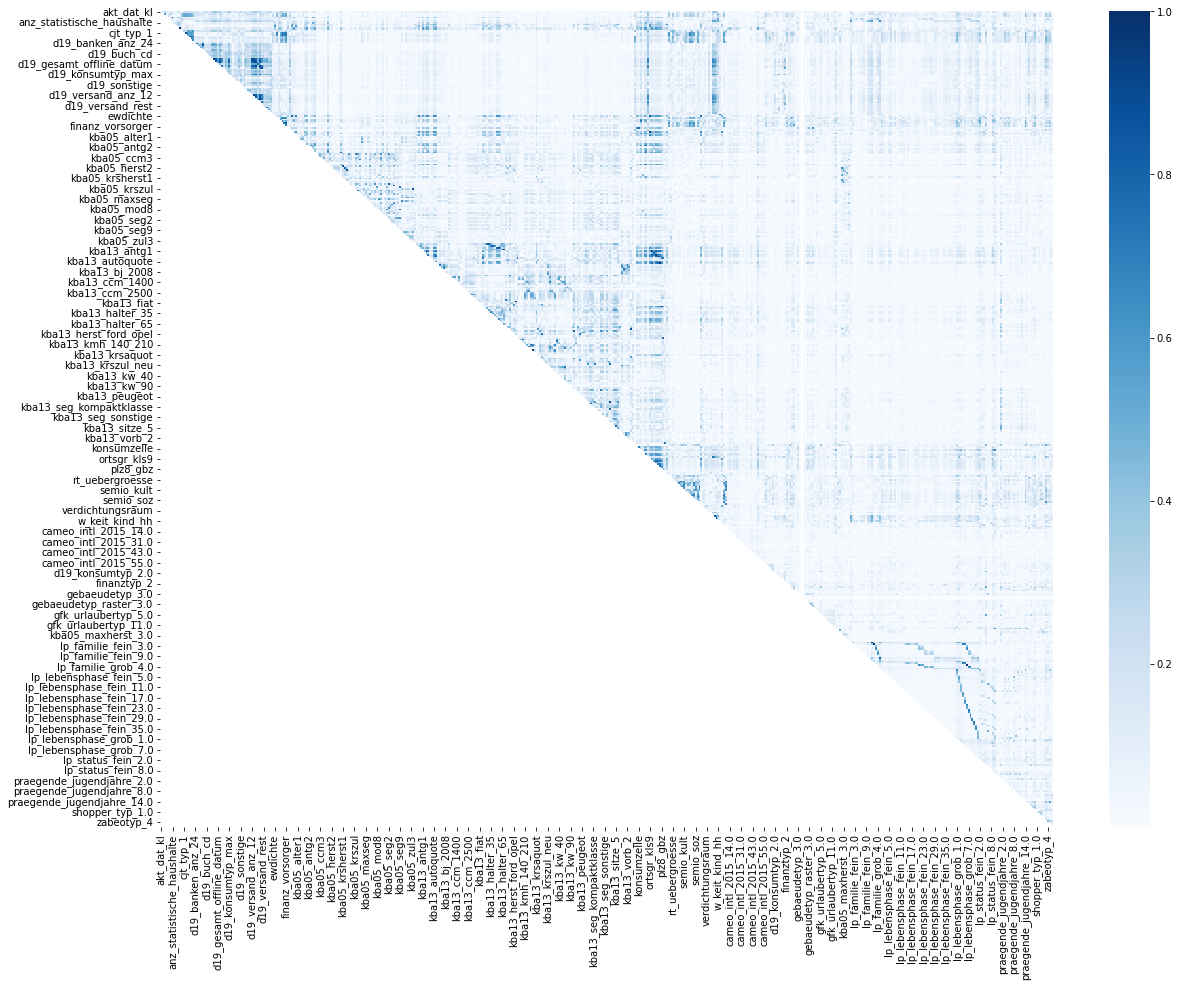

In [88]:
plt.figure(figsize=(20,15))
sns.heatmap(corr_df, cmap='Blues');

In [52]:
corr_df_max =(pd.concat([azdias,customers])
 .corr()
 .abs()
 .where(np.triu(np.ones((azdias.shape[1],azdias.shape[1])),k=1).astype(bool))
 .max()
 .sort_values(ascending=False)
 .to_frame()
 .reset_index()
)
corr_df_max.columns = ['column','correlation']
corr_df_max

,column,correlation
0,kba13_herst_sonst,1.000000
1,lp_lebensphase_grob_6.0,1.000000
2,lp_familie_grob_2.0,1.000000
3,lp_familie_grob_1.0,1.000000
4,cameo_deug_2015,0.993636
...,...,...
466,gebaeudetyp_4.0,0.041234
467,cameo_intl_2015_35.0,0.037836
468,gebaeudetyp_6.0,0.033075
469,gebaeudetyp_5.0,0.002476


In [57]:
corr_df_max.query('correlation > 0.95')

,column,correlation
0,kba13_herst_sonst,1.000000
1,lp_lebensphase_grob_6.0,1.000000
2,lp_familie_grob_2.0,1.000000
3,lp_familie_grob_1.0,1.000000
4,cameo_deug_2015,0.993636
5,anz_statistische_haushalte,0.978522
6,plz8_gbz,0.972456
7,kba13_kmh_250,0.960653
8,plz8_hhz,0.959480


In [59]:
corr_df_max.query('correlation > 0.95').column.values

array(['kba13_herst_sonst', 'lp_lebensphase_grob_6.0',
       'lp_familie_grob_2.0', 'lp_familie_grob_1.0', 'cameo_deug_2015',
       'anz_statistische_haushalte', 'plz8_gbz', 'kba13_kmh_250',
       'plz8_hhz'], dtype=object)

In [116]:
cols_colinearity = ['kba13_herst_sonst', 'lp_lebensphase_grob_6.0','lp_familie_grob_2.0', 'lp_familie_grob_1.0',\
                    'cameo_deug_2015','anz_statistische_haushalte', 'plz8_gbz', 'kba13_kmh_250','plz8_hhz']

In [117]:
azdias = azdias.drop(columns = cols_colinearity)
customers = customers.drop(columns = cols_colinearity)

In [118]:
azdias.shape, customers.shape

((891221, 462), (191652, 462))

# 3 Methodology
## 3.1 Data Preprocessing

### Library imports

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import GridSearchCV

### Data loading

In [2]:
customers = pd.read_csv('data/customers.csv')
azdias = pd.read_csv('data/azdias.csv') #, nrows = 100)
customers.columns = customers.columns.str.lower()
azdias.columns = azdias.columns.str.lower()

customers = customers.drop(columns=['unnamed: 0','lnr'])
azdias = azdias.drop(columns=['unnamed: 0','lnr'])

customers_extra_cols = customers[['customer_group', 'online_purchase', 'product_group']]
customers = customers.drop(columns = ['customer_group', 'online_purchase', 'product_group'])


dias_attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', index_col=False, skiprows=1)
dias_attributes.drop('Unnamed: 0', axis=1, inplace=True)
dias_attributes.columns = dias_attributes.columns.str.lower()
dias_attributes.attribute = dias_attributes.attribute.str.lower()
dias_attributes.ffill(inplace=True)

### Definition of functions for data cleaning

In [3]:
def remove_rz(x):
    '''
    Removes the last three characters '_rz' from a feature name in the dias_attributes dataset
    INPUT:
    x STR: The feature name that we want to rename, removing the '_rz' from the end
    OUTPUT
    x STR: The renamed feature
    EXAMPLE
    "d19_bekleidung_rest_rz" --> "d19_bekleidung_rest"
    '''
    try:
        if x[-2:] =='rz':
            return x[:-3] 
    except:
        return np.nan
    return x

def change_unknown_to_nan(df):
    '''
    Convert the unknown values of the dataset (-1, 0, 9... according to the DIAS file) to np.nan
    Also for the column geburtsjahr (birth year), chage 0 to NAN
    INPUT
    df DATAFRAME: pandas dataframe with the values we want to convert into nans
    OUTPUT
    df DATAFRAME: pandas dataframe with the values converted
    '''
    # Creating a dataframe from the DIAS file, with the unknown values
    unknowns= (dias_attributes
     .loc[dias_attributes.meaning.str.contains('unknown')]
     .assign(value = dias_attributes.value.map(str).str.split(','))
    )
    for col in unknowns.attribute.values:
        values = unknowns.query('attribute == @col').value.values[0]
        for value in values:
            df[col] = df[col].replace(int(value), np.nan)
    df['geburtsjahr'] =  df['geburtsjahr'].replace({0 : np.nan})
    return df

def get_columns_to_drop_nan(df, percent = 0.5):
    '''
    Get the columns to drop with the specified percentage of missing values
    from a given dataframe
    INPUT:
    df DATAFRAME: the dataframe in which we want to find the columns with missing values
    percent FLOAT: threshold of percentage of nulls to be selected (between 0 and 1)
    OUTPUT:
    cols LIST: a list of columns with more null values than the specified threshold
    '''
    cols = df.columns[df.isnull().mean()>0.5]
    return cols

def get_unbalanced_columns(df, percent=0.9):
    '''
    Get columns with a dominant value above a specified threshold
    INPUT:
    df DATAFRAME: pandas dataframe in which we want to find the columns
    percent FLOAT: frequency threshold for the dominant value (between 0 and 1)
    OUTPUT:
    cols LIST: list with unbalanced columns
    '''
    col_similar = []
    for col in df.columns:
        if df[col].value_counts(normalize=True).max()>0.9:
            col_similar.append(col)
    return col_similar

def cameo_deu_2015_to_numerical(df):
    '''
    Convert the column cameo_deu_2015 to numerical
    INPUT
    df DATAFRAME: pandas dataframe with a categorical cameo_deu_2015 column, with string values, that we want to
                  to convert in numerical values
    OUTPUT
    df DATAFRAME: pandas dataframe with the cameo_deu_2015 column converted into numerical values
    '''
    values = sorted(df.cameo_deu_2015.dropna().unique())
    df.cameo_deu_2015 = df.cameo_deu_2015.map({values[n]:n+1 for n in range(len(values)-1)})
    return df

def get_dummies_drop(df, col):
    '''
    Get dummie variables for one column, drop the original column from the dataframe,
    and concatenate the dummie variable columns to the original dataframe
    INPUT
    df DATAFRAME: pandas dataframe with the column we want to convert into dummy variables
    col STRING: the name of the column we want to convert into dummy variables
    OUTPUT
    df DATAFAME: pandas dataframe with the dummy variables columns 
    '''
    return pd.concat([df.drop(columns = col),
                   pd.get_dummies(df[col], prefix=col, drop_first=True)
                  ], axis=1)

def drop_last_obj_cols(df):
    '''
    Drop the last two object columns to clean: d19_letzter_kauf_branche and d19_unbekannt
    INPUT
    df DATAFRAME: pandas dataframe with the two object type columns to be dropped
    OUTPUT
    df DATAFRAME: pandas dataframe with the two object type columns dropped
    '''
    cols = ['d19_letzter_kauf_branche', 'eingefuegt_am']
    return df.drop(columns = cols)


def impute_nan(df):
    '''
    impute the missing values from the dataframe with the mode for the
    categorical columns or the mean for the rest of columns
    INPUT
    df DATAFRAME: pandas dataframe to be cleaned of null values
    OUTPUT
    df DATAFRAME: pandas dataframe without null values
    '''
    cat_ord = dias_attributes.loc[dias_attributes.type == 'cat_ord'].attribute.values
    cat_ord = np.intersect1d(cat_ord, df.columns)
    cols = df.columns[df.isnull().mean()>0]
    non_cat_to_drop = np.setdiff1d(cols,cat_ord)
    cat_to_drop = np.intersect1d(cols, cat_ord)
    return (df
     .assign(
         **{c:lambda df_, c=c: df_[c].fillna(df_[c].mean()) for c in non_cat_to_drop},
         **{c:lambda df_, c=c: df_[c].fillna(df_[c].mode().values[0]) for c in cat_to_drop}
             )
            ) 


### Data cleaning

In [4]:
dias_attributes.attribute = dias_attributes.attribute.apply(remove_rz)

dias_attributes.attribute = dias_attributes.attribute.replace({
    'd19_kk_kundentyp':'kk_kundentyp',
    'cameo_deuintl_2015':'cameo_intl_2015',
    'd19_buch':'d19_buch_cd',
    'kba13_ccm_1400_2500':'kba13_ccm_1401_2500',
    'bip_flag':'dsl_flag',
    'soho_flag':'soho_kz',
})

dias_attributes = dias_attributes.loc[(dias_attributes.attribute != 'geoscore_kls7')
                                      & (dias_attributes.attribute != 'haushaltsstruktur')
                                      & (dias_attributes.attribute != 'wachstumsgebiet_nb')]

In [5]:
azdias = change_unknown_to_nan(azdias)
customers = change_unknown_to_nan(customers)

column_with_nan = get_columns_to_drop_nan(azdias, percent = 0.5)
azdias = azdias.drop(columns=column_with_nan)
customers = customers.drop(columns=column_with_nan)

col_similar = get_unbalanced_columns(azdias, percent=0.9)
azdias = azdias.drop(columns = col_similar)
customers = customers.drop(columns = col_similar)

azdias = cameo_deu_2015_to_numerical(azdias)
customers = cameo_deu_2015_to_numerical(customers)

cat_nom = dias_attributes.loc[dias_attributes.type == 'cat_nom'].attribute.values
cat_nom = np.intersect1d(cat_nom, azdias.columns)
for col in cat_nom:
    azdias = get_dummies_drop(azdias, col)
for col in cat_nom:
    customers = get_dummies_drop(customers, col)
customers['gebaeudetyp_5.0']= 0

azdias = drop_last_obj_cols(azdias)
customers = drop_last_obj_cols(customers)

customers = impute_nan(customers)
azdias = impute_nan(azdias)

cols_colinearity = ['kba13_herst_sonst', 'lp_lebensphase_grob_6.0','lp_familie_grob_2.0', 'lp_familie_grob_1.0',\
                    'cameo_deug_2015','anz_statistische_haushalte', 'plz8_gbz', 'kba13_kmh_250','plz8_hhz']
azdias = azdias.drop(columns = cols_colinearity)
customers = customers.drop(columns = cols_colinearity)



### Saving of cleaned data as pickle files for later use

In [8]:
pd.DataFrame.to_pickle(azdias, 'azdias_cleaned.pkl')
pd.DataFrame.to_pickle(customers, 'customers_cleaned.pkl')
pd.DataFrame.to_pickle(customers_extra_cols, 'customers_extra_cols.pkl')

### Loading cleaned data

In [2]:
azdias = pd.read_pickle('azdias_cleaned.pkl')
customers = pd.read_pickle('customers_cleaned.pkl')
customers_extra_cols = pd.read_pickle('customers_extra_cols.pkl')

In [3]:
customers_extra_cols = (customers_extra_cols
 .assign(customer_group = lambda df_: df_.customer_group.astype('category'))
 .assign(product_group = lambda df_: df_.product_group.astype('category'))
)

In [23]:
# customers = pd.concat([customers, customers_extra_cols],axis=1).shape

In [5]:
for c in customers_extra_cols.columns:
    print(customers_extra_cols[c].value_counts(), '\n')

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: customer_group, dtype: int64 

0    174356
1     17296
Name: online_purchase, dtype: int64 

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: product_group, dtype: int64 



#### In order to keep track of the individual datasets after we combine them, we create a new column.

In [3]:
azdias['dataset'] = 'azdias'
customers['dataset'] = 'customer'
combined = pd.concat([azdias,customers]).sample(frac=1)

In [4]:
scaler = StandardScaler()

In [5]:
scaler.fit(azdias.drop(columns = ['dataset']))

StandardScaler()

In [6]:
del azdias
del customers

In [7]:
x_scale = pd.DataFrame(scaler.transform(combined.drop(columns = ['dataset'])), 
                       columns = combined.drop(columns = ['dataset']).columns)
x_scale['dataset'] = combined['dataset'].values

Configuramos PCA para preserver el 90% de variabilidad en los datos

In [8]:
pca = PCA(n_components=235)
x_pca = pca.fit_transform(x_scale.drop(columns=['dataset']))

In [9]:
x_pca.shape

(1082873, 235)

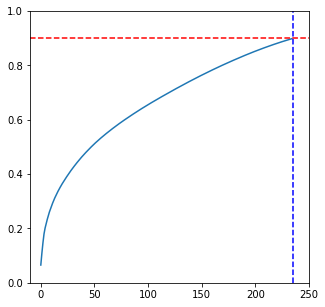

In [10]:
plt.figure(figsize=(5,5))
# plt.plot([np.sum(pca.explained_variance_ratio_[:i+1]) for i in range(462)])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y = 0.9, ls='--', c='r')
plt.axvline(x = 235, ls='--', c='b')
plt.ylim((0,1))
plt.xlim((-10,250))
plt.show()

In [27]:
clusters = []
for i in range(2,20):
    km = KMeans(n_clusters=i).fit(x_pca)
    clusters.append(km.inertia_)

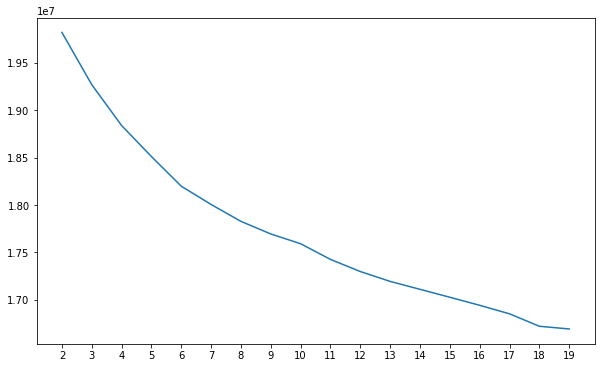

In [28]:
plt.figure(figsize=(10,6))
plt.plot(range(2,20), clusters)
plt.xticks(list(range(2,20)))
plt.show()

Vamos a usar PCA con 235 features, y vamos a usar KMeans con 9 clusters

In [11]:
km = KMeans(n_clusters=9).fit(x_pca)

In [12]:
clusters = km.labels_
combined['cluster'] = clusters

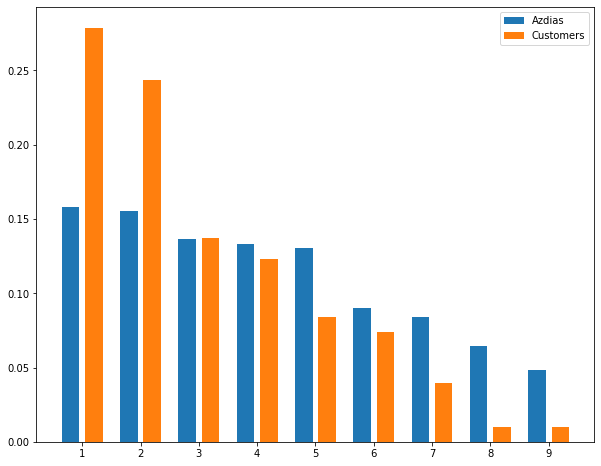

In [13]:
fig, ax =plt.subplots(figsize=(10,8))
ax.bar(np.arange(9)+0.8, combined.query('dataset == "azdias"').cluster.value_counts(normalize=True), 0.3, label = 'Azdias')
ax.bar(np.arange(9)+1.2, combined.query('dataset == "customer"').cluster.value_counts(normalize=True), 0.3, label = 'Customers')
plt.xticks((np.arange(1,10)))
ax.legend()
plt.show()

We can see that clusters 1 and 2 are the clusters with the highest representation of customers.  
Clusters 3 and 4 have a medium representation of customers.  
Clusters 5 to 7 have a low representation of customers, while clusters 8 and 9 have almost no representation.  
After this segmentation, we can estimate which part of the population is most likely to be a potential customer, with clusters 1 and 2 being the main target groups.


## Part 2: Supervised Learning Model
Now that we have discovered which parts of the population are most likely to be customers of the mail order company, it is time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual who was the subject of a mailing campaign. We will use each individual's demographic information to decide whether or not that person is worth including in the campaign.

The "MAILOUT" data has been divided into two roughly equal parts, each with almost 43,000 rows of data. In this part, we will check the model with the "TRAIN" partition, which includes a column, "RESPONSE", indicating whether or not a person became a customer of the company after the campaign. In the next part, we will create predictions in the "TEST" partition, where the column "RESPONSE" has been retained.

In [5]:
mailout_train = pd.read_pickle('mailout_train.pkl')
mailout_test = pd.read_pickle('mailout_test.pkl')

mailout_train.columns = mailout_train.columns.str.lower()
mailout_test.columns = mailout_test.columns.str.lower()

# customers = customers.drop(columns=['unnamed: 0','lnr'])
# azdias = azdias.drop(columns=['unnamed: 0','lnr'])

# customers_extra_cols = customers[['customer_group', 'online_purchase', 'product_group']]
# customers = customers.drop(columns = ['customer_group', 'online_purchase', 'product_group'])

In [6]:
mailout_train.shape, mailout_test.shape

((42962, 367), (42833, 366))

In [16]:
mailout_train.head()

,lnr,ager_typ,akt_dat_kl,alter_hh,alter_kind1,alter_kind2,alter_kind3,alter_kind4,alterskategorie_fein,anz_haushalte_aktiv,anz_hh_titel,anz_kinder,anz_personen,anz_statistische_haushalte,anz_titel,arbeit,ballraum,cameo_deu_2015,cameo_deug_2015,cameo_intl_2015,cjt_gesamttyp,cjt_katalognutzer,cjt_typ_1,cjt_typ_2,cjt_typ_3,cjt_typ_4,cjt_typ_5,cjt_typ_6,d19_banken_anz_12,d19_banken_anz_24,d19_banken_datum,d19_banken_direkt,d19_banken_gross,d19_banken_lokal,d19_banken_offline_datum,d19_banken_online_datum,d19_banken_online_quote_12,d19_banken_rest,d19_bekleidung_geh,d19_bekleidung_rest,d19_bildung,d19_bio_oeko,d19_buch_cd,d19_digit_serv,d19_drogerieartikel,d19_energie,d19_freizeit,d19_garten,d19_gesamt_anz_12,d19_gesamt_anz_24,d19_gesamt_datum,d19_gesamt_offline_datum,d19_gesamt_online_datum,d19_gesamt_online_quote_12,d19_handwerk,d19_haus_deko,d19_kinderartikel,d19_konsumtyp,d19_konsumtyp_max,d19_kosmetik,d19_lebensmittel,d19_letzter_kauf_branche,d19_lotto,d19_nahrungsergaenzung,d19_ratgeber,d19_reisen,d19_sammelartikel,d19_schuhe,d19_sonstige,d19_soziales,d19_technik,d19_telko_anz_12,d19_telko_anz_24,d19_telko_datum,d19_telko_mobile,d19_telko_offline_datum,d19_telko_online_datum,d19_telko_online_quote_12,d19_telko_rest,d19_tierartikel,d19_versand_anz_12,d19_versand_anz_24,d19_versand_datum,d19_versand_offline_datum,d19_versand_online_datum,d19_versand_online_quote_12,d19_versand_rest,d19_versi_anz_12,d19_versi_anz_24,d19_versi_datum,d19_versi_offline_datum,d19_versi_online_datum,d19_versi_online_quote_12,d19_versicherungen,d19_vollsortiment,d19_wein_feinkost,dsl_flag,eingefuegt_am,eingezogenam_hh_jahr,ewdichte,extsel992,finanz_anleger,finanz_hausbauer,finanz_minimalist,finanz_sparer,finanz_unauffaelliger,finanz_vorsorger,finanztyp,firmendichte,gebaeudetyp,gebaeudetyp_raster,geburtsjahr,gemeindetyp,gfk_urlaubertyp,green_avantgarde,health_typ,hh_delta_flag,hh_einkommen_score,innenstadt,kba05_alter1,kba05_alter2,kba05_alter3,kba05_alter4,kba05_anhang,kba05_antg1,kba05_antg2,kba05_antg3,kba05_antg4,kba05_autoquot,kba05_baumax,kba05_ccm1,kba05_ccm2,kba05_ccm3,kba05_ccm4,kba05_diesel,kba05_frau,kba05_gbz,kba05_herst1,kba05_herst2,kba05_herst3,kba05_herst4,kba05_herst5,kba05_hersttemp,kba05_krsaquot,kba05_krsherst1,kba05_krsherst2,kba05_krsherst3,kba05_krsklein,kba05_krsober,kba05_krsvan,kba05_krszul,kba05_kw1,kba05_kw2,kba05_kw3,kba05_maxah,kba05_maxbj,kba05_maxherst,kba05_maxseg,kba05_maxvorb,kba05_mod1,kba05_mod2,kba05_mod3,kba05_mod4,kba05_mod8,kba05_modtemp,kba05_motor,kba05_motrad,kba05_seg1,kba05_seg10,kba05_seg2,kba05_seg3,kba05_seg4,kba05_seg5,kba05_seg6,kba05_seg7,kba05_seg8,kba05_seg9,kba05_vorb0,kba05_vorb1,kba05_vorb2,kba05_zul1,kba05_zul2,kba05_zul3,kba05_zul4,kba13_alterhalter_30,kba13_alterhalter_45,kba13_alterhalter_60,kba13_alterhalter_61,kba13_antg1,kba13_antg2,kba13_antg3,kba13_antg4,kba13_anzahl_pkw,kba13_audi,kba13_autoquote,kba13_baumax,kba13_bj_1999,kba13_bj_2000,kba13_bj_2004,kba13_bj_2006,kba13_bj_2008,kba13_bj_2009,kba13_bmw,kba13_ccm_0_1400,kba13_ccm_1000,kba13_ccm_1200,kba13_ccm_1400,kba13_ccm_1401_2500,kba13_ccm_1500,kba13_ccm_1600,kba13_ccm_1800,kba13_ccm_2000,kba13_ccm_2500,kba13_ccm_2501,kba13_ccm_3000,kba13_ccm_3001,kba13_fab_asien,kba13_fab_sonstige,kba13_fiat,kba13_ford,kba13_gbz,kba13_halter_20,kba13_halter_25,kba13_halter_30,kba13_halter_35,kba13_halter_40,kba13_halter_45,kba13_halter_50,kba13_halter_55,kba13_halter_60,kba13_halter_65,kba13_halter_66,kba13_herst_asien,kba13_herst_audi_vw,kba13_herst_bmw_benz,kba13_herst_europa,kba13_herst_ford_opel,kba13_herst_sonst,kba13_hhz,kba13_kmh_0_140,kba13_kmh_110,kba13_kmh_140,kba13_kmh_140_210,kba13_kmh_180,kba13_kmh_210,kba13_kmh_211,kba13_kmh_250,kba13_kmh_251,kba13_krsaquot,kba13_krsherst_audi_vw,kba13_krsherst_bmw_benz,kba13_krsherst_ford_opel,kba13_krsseg_klein,kba13_krsseg_ober,kba13_krsseg_van,kba13_krszul_neu,kba13_kw_0_60,kba13_kw_110,kba13_kw_120,kba13_kw_121,kba13_kw_30,kba13_kw_40,kba13_kw_50,kba13_kw_60,kba13_kw_61_120,kba13_kw_70,kba13_kw_80,

In [17]:
mailout_test.head()

,lnr,ager_typ,akt_dat_kl,alter_hh,alter_kind1,alter_kind2,alter_kind3,alter_kind4,alterskategorie_fein,anz_haushalte_aktiv,anz_hh_titel,anz_kinder,anz_personen,anz_statistische_haushalte,anz_titel,arbeit,ballraum,cameo_deu_2015,cameo_deug_2015,cameo_intl_2015,cjt_gesamttyp,cjt_katalognutzer,cjt_typ_1,cjt_typ_2,cjt_typ_3,cjt_typ_4,cjt_typ_5,cjt_typ_6,d19_banken_anz_12,d19_banken_anz_24,d19_banken_datum,d19_banken_direkt,d19_banken_gross,d19_banken_lokal,d19_banken_offline_datum,d19_banken_online_datum,d19_banken_online_quote_12,d19_banken_rest,d19_bekleidung_geh,d19_bekleidung_rest,d19_bildung,d19_bio_oeko,d19_buch_cd,d19_digit_serv,d19_drogerieartikel,d19_energie,d19_freizeit,d19_garten,d19_gesamt_anz_12,d19_gesamt_anz_24,d19_gesamt_datum,d19_gesamt_offline_datum,d19_gesamt_online_datum,d19_gesamt_online_quote_12,d19_handwerk,d19_haus_deko,d19_kinderartikel,d19_konsumtyp,d19_konsumtyp_max,d19_kosmetik,d19_lebensmittel,d19_letzter_kauf_branche,d19_lotto,d19_nahrungsergaenzung,d19_ratgeber,d19_reisen,d19_sammelartikel,d19_schuhe,d19_sonstige,d19_soziales,d19_technik,d19_telko_anz_12,d19_telko_anz_24,d19_telko_datum,d19_telko_mobile,d19_telko_offline_datum,d19_telko_online_datum,d19_telko_online_quote_12,d19_telko_rest,d19_tierartikel,d19_versand_anz_12,d19_versand_anz_24,d19_versand_datum,d19_versand_offline_datum,d19_versand_online_datum,d19_versand_online_quote_12,d19_versand_rest,d19_versi_anz_12,d19_versi_anz_24,d19_versi_datum,d19_versi_offline_datum,d19_versi_online_datum,d19_versi_online_quote_12,d19_versicherungen,d19_vollsortiment,d19_wein_feinkost,dsl_flag,eingefuegt_am,eingezogenam_hh_jahr,ewdichte,extsel992,finanz_anleger,finanz_hausbauer,finanz_minimalist,finanz_sparer,finanz_unauffaelliger,finanz_vorsorger,finanztyp,firmendichte,gebaeudetyp,gebaeudetyp_raster,geburtsjahr,gemeindetyp,gfk_urlaubertyp,green_avantgarde,health_typ,hh_delta_flag,hh_einkommen_score,innenstadt,kba05_alter1,kba05_alter2,kba05_alter3,kba05_alter4,kba05_anhang,kba05_antg1,kba05_antg2,kba05_antg3,kba05_antg4,kba05_autoquot,kba05_baumax,kba05_ccm1,kba05_ccm2,kba05_ccm3,kba05_ccm4,kba05_diesel,kba05_frau,kba05_gbz,kba05_herst1,kba05_herst2,kba05_herst3,kba05_herst4,kba05_herst5,kba05_hersttemp,kba05_krsaquot,kba05_krsherst1,kba05_krsherst2,kba05_krsherst3,kba05_krsklein,kba05_krsober,kba05_krsvan,kba05_krszul,kba05_kw1,kba05_kw2,kba05_kw3,kba05_maxah,kba05_maxbj,kba05_maxherst,kba05_maxseg,kba05_maxvorb,kba05_mod1,kba05_mod2,kba05_mod3,kba05_mod4,kba05_mod8,kba05_modtemp,kba05_motor,kba05_motrad,kba05_seg1,kba05_seg10,kba05_seg2,kba05_seg3,kba05_seg4,kba05_seg5,kba05_seg6,kba05_seg7,kba05_seg8,kba05_seg9,kba05_vorb0,kba05_vorb1,kba05_vorb2,kba05_zul1,kba05_zul2,kba05_zul3,kba05_zul4,kba13_alterhalter_30,kba13_alterhalter_45,kba13_alterhalter_60,kba13_alterhalter_61,kba13_antg1,kba13_antg2,kba13_antg3,kba13_antg4,kba13_anzahl_pkw,kba13_audi,kba13_autoquote,kba13_baumax,kba13_bj_1999,kba13_bj_2000,kba13_bj_2004,kba13_bj_2006,kba13_bj_2008,kba13_bj_2009,kba13_bmw,kba13_ccm_0_1400,kba13_ccm_1000,kba13_ccm_1200,kba13_ccm_1400,kba13_ccm_1401_2500,kba13_ccm_1500,kba13_ccm_1600,kba13_ccm_1800,kba13_ccm_2000,kba13_ccm_2500,kba13_ccm_2501,kba13_ccm_3000,kba13_ccm_3001,kba13_fab_asien,kba13_fab_sonstige,kba13_fiat,kba13_ford,kba13_gbz,kba13_halter_20,kba13_halter_25,kba13_halter_30,kba13_halter_35,kba13_halter_40,kba13_halter_45,kba13_halter_50,kba13_halter_55,kba13_halter_60,kba13_halter_65,kba13_halter_66,kba13_herst_asien,kba13_herst_audi_vw,kba13_herst_bmw_benz,kba13_herst_europa,kba13_herst_ford_opel,kba13_herst_sonst,kba13_hhz,kba13_kmh_0_140,kba13_kmh_110,kba13_kmh_140,kba13_kmh_140_210,kba13_kmh_180,kba13_kmh_210,kba13_kmh_211,kba13_kmh_250,kba13_kmh_251,kba13_krsaquot,kba13_krsherst_audi_vw,kba13_krsherst_bmw_benz,kba13_krsherst_ford_opel,kba13_krsseg_klein,kba13_krsseg_ober,kba13_krsseg_van,kba13_krszul_neu,kba13_kw_0_60,kba13_kw_110,kba13_kw_120,kba13_kw_121,kba13_kw_30,kba13_kw_40,kba13_kw_50,kba13_kw_60,kba13_kw_61_120,kba13_kw_70,kba13_kw_80,

In [6]:
def cleaning(df1, df2):
    response = df1.response
    df1 = df1.drop(columns='response')
    print('Changing unknows to nan')
    change_unknown_to_nan(df1)
    change_unknown_to_nan(df2)
    print('Dropping columns with 50% or more nans')
    column_with_nan = get_columns_to_drop_nan(df1, percent = 0.5)
    df1 = df1.drop(columns=column_with_nan)
    df2 = df2.drop(columns=column_with_nan)
    print('Dropping columns with similar values')
    col_similar = get_unbalanced_columns(df1, percent=0.9)
    df1 = df1.drop(columns = col_similar)
    df2 = df2.drop(columns = col_similar)
    print('Converting cameo column to numerical')
    df1 = cameo_deu_2015_to_numerical(df1)
    df2 = cameo_deu_2015_to_numerical(df2)
    print('Hot encodding categorical columns')
    cat_nom = dias_attributes.loc[dias_attributes.type == 'cat_nom'].attribute.values
    cat_nom = np.intersect1d(cat_nom, df1.columns)
    for col in cat_nom:
        df1 = get_dummies_drop(df1, col)
    for col in cat_nom:
        df2 = get_dummies_drop(df2, col)
    print('Dropping last object columns')
    df1 = drop_last_obj_cols(df1)
    df2 = drop_last_obj_cols(df2)
    print('Imputting missing values')
    df1 = impute_nan(df1)
    df2 = impute_nan(df2)
    print('Dropping columns with hight colinearyty')
    cols_colinearity = ['kba13_herst_sonst', 'lp_lebensphase_grob_6.0','lp_familie_grob_2.0', 'lp_familie_grob_1.0',\
                    'cameo_deug_2015','anz_statistische_haushalte', 'plz8_gbz', 'kba13_kmh_250','plz8_hhz']
    df1 = df1.drop(columns = cols_colinearity)
    df2 = df2.drop(columns = cols_colinearity)
    print('Done!')
    df1['response'] = response

    return df1, df2
    

In [7]:
mailout_train_clean, mailout_test_clean = cleaning(mailout_train, mailout_test)

Changing unknows to nan
Dropping columns with 50% or more nans
Dropping columns with similar values
Converting cameo column to numerical
Hot encodding categorical columns
Dropping last object columns
Imputting missing values
Dropping columns with hight colinearyty
Done!


In [8]:
mailout_train_clean.shape, mailout_test_clean.shape

((42962, 469), (42833, 468))

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
                    mailout_train_clean.drop(columns=['response']), 
                    mailout_train_clean.response,  
                    test_size=0.3, random_state=15)

In [102]:
param_grid = [
    {'gamma':[0.0001],'max_depth':[5,6,7]},
    ]
strat_kf = StratifiedKFold()
xgb = XGBClassifier(eval_metric='auc',n_estimators=6, learning_rate=0.1,scale_pos_weight=20)
grid_search = GridSearchCV(xgb,
                     param_grid,
                     cv=strat_kf,
                     scoring = 'roc_auc',
                     return_train_score=True
)


grid_search.fit(X_train.drop(columns ='lnr'), y_train)
# grid_search.fit(mailout_train_clean.drop(columns=['response','lnr']), mailout_train_clean['response'])

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance...
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=6, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid=[{'gamma': [0.0001], 'max_depth': [5, 6, 7]}],
             return_train_score=True, scoring='roc_auc')

In [103]:
grid_search.best_params_

{'gamma': 0.0001, 'max_depth': 5}

In [104]:
grid_search.best_score_

0.7613026972501811

In [106]:
best_model = grid_search.best_estimator_
pred = best_model.predict_proba(X_test.drop(columns ='lnr'))
pred_train = best_model.predict_proba(X_train.drop(columns ='lnr'))
roc_auc_score(y_train, pred_train[:,1]),roc_auc_score(y_test, pred[:,1])

(0.8727153066250926, 0.7551287328360073)

## Feature Importance

In [136]:
importance = (pd.DataFrame({'features':best_model.feature_names_in_, 'importance':best_model.feature_importances_})
 .sort_values(by='importance', ascending=False)
)
importance = importance.head(10).sort_values(by='importance')

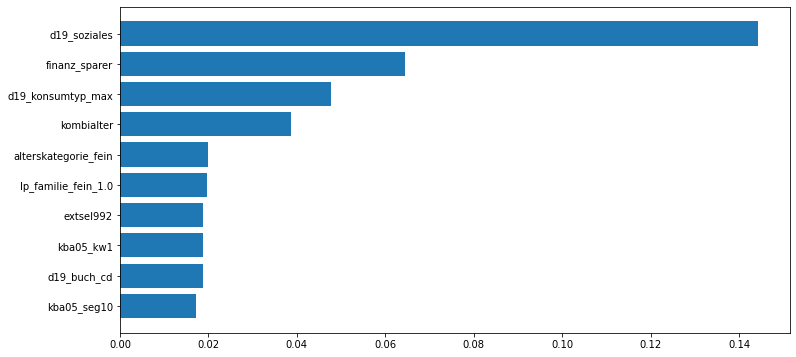

In [137]:
plt.figure(figsize=(12,6))
plt.barh(importance.features,importance.importance);

## Predictions for the kaggle competition

In [109]:
pred = best_model.predict_proba(mailout_test_clean.drop(columns=['lnr'])) 
pred_df = pd.DataFrame({'LNR':mailout_test_clean['lnr'],'RESPONSE':pred[:,1]})
pd.DataFrame.to_csv(pred_df, 'predictionsfinal.csv', index=False)